In [5]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [6]:
IMAGE_SIZE = (150, 150)
NUM_CLASSES = 26  # Number of plant disease classes
BATCH_SIZE = 32
DATASET_PATH = "plant_dataset_main"
TRAIN_PATH = os.path.join(DATASET_PATH, "train", "diseased")
VALID_PATH = os.path.join(DATASET_PATH, "valid", "diseased")
TRAIN_PICKLE_FILE = "train_data_diseased.pkl"
VALID_PICKLE_FILE = "valid_data_diseased.pkl"

In [6]:
def load_images_from_folder(folder_path, num_samples_per_class):
    X, Y = [], []
    class_labels = sorted(os.listdir(folder_path))  # Get class names
    label_map = {label: idx for idx, label in enumerate(class_labels)}
    class_counts = {label: 0 for label in class_labels}
    
    for class_name in class_labels:
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue
        
        images = sorted(os.listdir(class_folder))[:num_samples_per_class]  # Take a subset of images
        class_counts[class_name] = len(images)
        for image_name in images:
            image_path = os.path.join(class_folder, image_name)
            image = load_img(image_path, target_size=IMAGE_SIZE)
            image_array = img_to_array(image) / 255.0  # Normalize
            X.append(image_array)
            Y.append(label_map[class_name])
    
    return np.array(X), np.array(Y), label_map, class_counts

In [7]:
# Load dataset
print("Loading dataset...")
X_train, Y_train, label_map, train_counts = load_images_from_folder(TRAIN_PATH, 300)
X_valid, Y_valid, _, valid_counts = load_images_from_folder(VALID_PATH, 75)

Loading dataset...


In [8]:
# Convert labels to one-hot encoding
Y_train = to_categorical(Y_train, num_classes=NUM_CLASSES)
Y_valid = to_categorical(Y_valid, num_classes=NUM_CLASSES)

In [9]:
# Pickle the training dataset
with open(TRAIN_PICKLE_FILE, "wb") as f:
    pickle.dump((X_train, Y_train, label_map, train_counts), f)
print("Training dataset saved as pickle.")
print("Training class counts:", train_counts)

# Pickle the validation dataset
with open(VALID_PICKLE_FILE, "wb") as f:
    pickle.dump((X_valid, Y_valid, label_map, valid_counts), f)
print("Validation dataset saved as pickle.")
print("Validation class counts:", valid_counts)

Training dataset saved as pickle.
Training class counts: {'Apple___Apple_scab': 300, 'Apple___Black_rot': 300, 'Apple___Cedar_apple_rust': 300, 'Bell_pepper___Bacterial_spot': 300, 'Cherry_(including_sour)___Powdery_mildew': 300, 'Corn_(maize)___Cercospora_leaf_spot or Gray_leaf_spot': 300, 'Corn_(maize)___Common_rust_': 300, 'Corn_(maize)___Northern_Leaf_Blight': 300, 'Grape___Black_rot': 300, 'Grape___Esca_(Black_Measles)': 300, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 300, 'Orange___Haunglongbing_(Citrus_greening)': 300, 'Peach___Bacterial_spot': 300, 'Potato___Early_blight': 300, 'Potato___Late_blight': 300, 'Squash___Powdery_mildew': 300, 'Strawberry___Leaf_scorch': 300, 'Tomato___Bacterial_spot': 300, 'Tomato___Early_blight': 300, 'Tomato___Late_blight': 300, 'Tomato___Leaf_Mold': 300, 'Tomato___Septoria_leaf_spot': 300, 'Tomato___Spider_mites Two-spotted_spider_mite': 300, 'Tomato___Target_Spot': 300, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 300, 'Tomato___Tomato_mosaic_vi

In [7]:
# Check if pickle files exist
if os.path.exists(TRAIN_PICKLE_FILE) and os.path.exists(VALID_PICKLE_FILE):
    print("Pickle files found. Loading datasets...")

    # Load training dataset
    with open(TRAIN_PICKLE_FILE, "rb") as f:
        X_train, Y_train, label_map, train_counts = pickle.load(f)
    print("Training dataset loaded.")
    print("Training class counts:", train_counts)

    # Load validation dataset
    with open(VALID_PICKLE_FILE, "rb") as f:
        X_valid, Y_valid, label_map, valid_counts = pickle.load(f)
    print("Validation dataset loaded.")
    print("Validation class counts:", valid_counts)

else:
    print("Pickle files not found. Please run the dataset preparation script first.")

Pickle files found. Loading datasets...
Training dataset loaded.
Training class counts: {'Apple___Apple_scab': 300, 'Apple___Black_rot': 300, 'Apple___Cedar_apple_rust': 300, 'Bell_pepper___Bacterial_spot': 300, 'Cherry_(including_sour)___Powdery_mildew': 300, 'Corn_(maize)___Cercospora_leaf_spot or Gray_leaf_spot': 300, 'Corn_(maize)___Common_rust_': 300, 'Corn_(maize)___Northern_Leaf_Blight': 300, 'Grape___Black_rot': 300, 'Grape___Esca_(Black_Measles)': 300, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 300, 'Orange___Haunglongbing_(Citrus_greening)': 300, 'Peach___Bacterial_spot': 300, 'Potato___Early_blight': 300, 'Potato___Late_blight': 300, 'Squash___Powdery_mildew': 300, 'Strawberry___Leaf_scorch': 300, 'Tomato___Bacterial_spot': 300, 'Tomato___Early_blight': 300, 'Tomato___Late_blight': 300, 'Tomato___Leaf_Mold': 300, 'Tomato___Septoria_leaf_spot': 300, 'Tomato___Spider_mites Two-spotted_spider_mite': 300, 'Tomato___Target_Spot': 300, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 

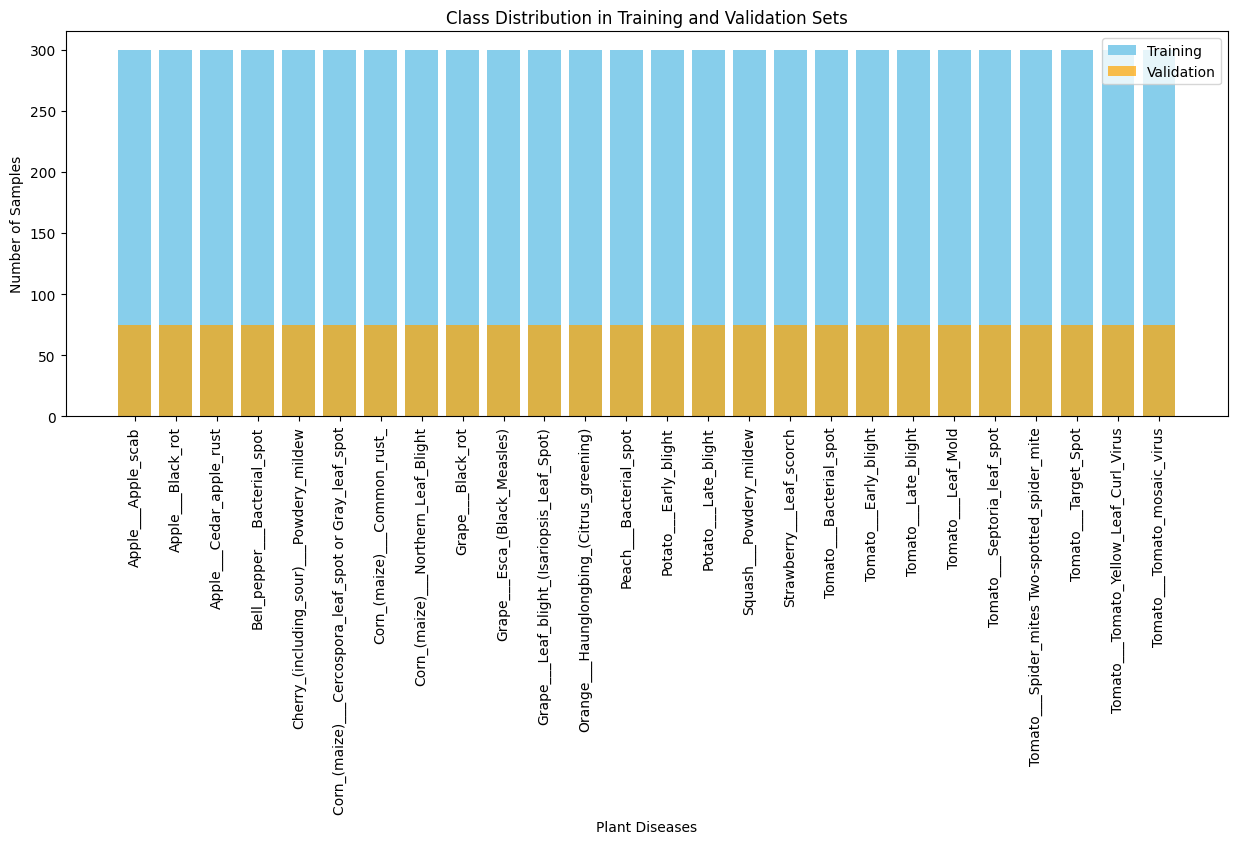

In [11]:
import matplotlib.pyplot as plt

# Training data
train_classes = list(train_counts.keys())
train_values = list(train_counts.values())

# Validation data
valid_classes = list(valid_counts.keys())
valid_values = list(valid_counts.values())

# Plot training data
plt.figure(figsize=(15, 5))
plt.bar(train_classes, train_values, color='skyblue', label='Training')
plt.bar(valid_classes, valid_values, color='orange', label='Validation', alpha=0.7)
plt.xticks(rotation=90)
plt.xlabel("Plant Diseases")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training and Validation Sets")
plt.legend()
plt.show()

In [4]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE)

In [20]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.00015) #1e-6

In [19]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
    
model.summary()

model.compile(optimizer=Adam(learning_rate=0.0002),
                loss='categorical_crossentropy',
                metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,826,714 (26.04 MB)

 Trainable params: 6,825,754 (26.04 MB)

 Non-trainable params: 960 (3.75 KB)

In [13]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,  # Stop if val_loss doesn’t improve for 5 epochs
    restore_best_weights=True
)

In [ ]:
EPOCHS = 20

history = model.fit(
    train_generator,
    validation_data=(X_valid, Y_valid),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

In [20]:
import json

# Save history as a JSON file
with open("training_history_3.json","w") as f:
    json.dump(history.history, f)

In [ ]:
# Save the trained model
model.save("disease_detection_model_3.h5")
print("Model saved successfully.")

Model saved successfully.


{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step


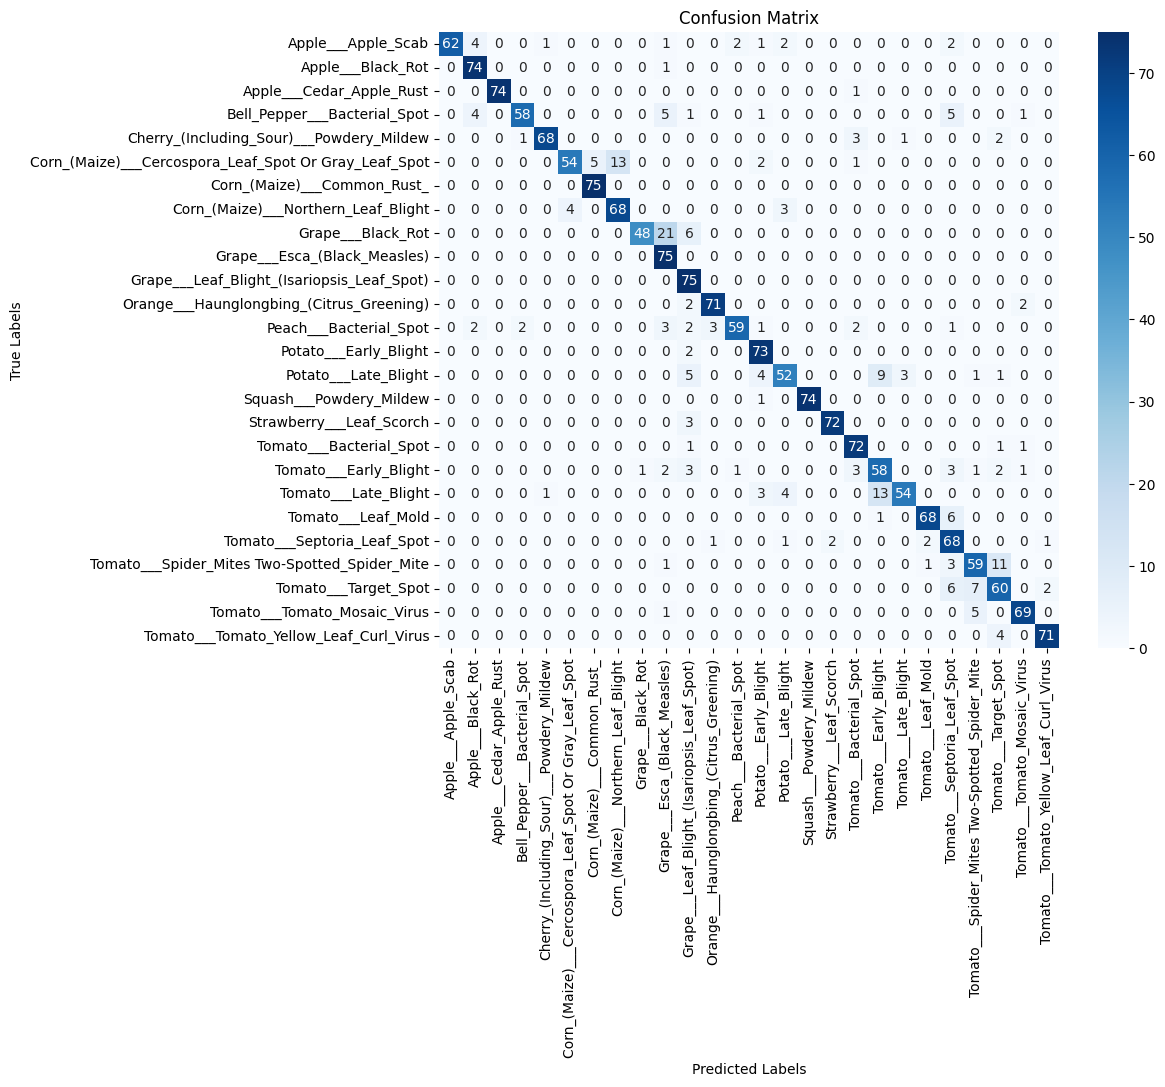

                                                       precision    recall  f1-score   support

                                   Apple___Apple_Scab       1.00      0.83      0.91        75
                                    Apple___Black_Rot       0.88      0.99      0.93        75
                             Apple___Cedar_Apple_Rust       1.00      0.99      0.99        75
                         Bell_Pepper___Bacterial_Spot       0.95      0.77      0.85        75
             Cherry_(Including_Sour)___Powdery_Mildew       0.97      0.91      0.94        75
Corn_(Maize)___Cercospora_Leaf_Spot Or Gray_Leaf_Spot       0.93      0.72      0.81        75
                          Corn_(Maize)___Common_Rust_       0.94      1.00      0.97        75
                  Corn_(Maize)___Northern_Leaf_Blight       0.84      0.91      0.87        75
                                    Grape___Black_Rot       0.98      0.64      0.77        75
                         Grape___Esca_(Black_Meas

In [9]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Load the saved Keras model
model_path = "plant_disease_website\\models\\multi_model.h5"  # Change this to your model path
model = tf.keras.models.load_model(model_path)

# Load class labels from CSV file
csv_path = "plant_disease_website\\plant_diseases_data.csv"  # Change this to your CSV file path

import chardet

with open(csv_path, "rb") as f:
    result = chardet.detect(f.read(100000))  # Read first 100KB for detection
    print(result)  # Check detected encoding

df = pd.read_csv(csv_path, encoding=result["encoding"])

# Extract class labels from 'Folder Name' column in title case
class_labels = df['Folder Name'].dropna().unique().tolist()
class_labels = [str(label).title() for label in class_labels]

if len(Y_valid.shape) > 1 and Y_valid.shape[1] > 1:  
    Y_valid = np.argmax(Y_valid, axis=1)  # Convert one-hot to integer labels

# Perform inference
y_pred_probs = model.predict(X_valid)  # Get probability outputs
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert predictions to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_valid, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(Y_valid, y_pred, target_names=class_labels))